In [1168]:
import pandas as pd
import numpy as np

# Result:
## Model: GradientBoostingRegressor(learning_rate=0.1, n_estimators=600)
## Performance: r2_score, 0.6255364342923583
## Feature Importance: median_income, ocean_proximity_<1H OCEAN

# Questions:
## 1. How to choose RFECV estimator?

In [1169]:
RANDOM_SEED = 42
DOWNLOAD_PATH = 'https://github.com/ageron/handson-ml/raw/master/datasets/housing/housing.tgz'
SAVING_PATH = os.path.join('datasets', 'housing')

In [1170]:
# 1. Get the Data

# 1.1 Download Data

import os
import tarfile
import requests


def download_file(download_path, saving_path):
    if not os.path.isdir(saving_path):
        os.makedirs(saving_path)
    filename = os.path.join(saving_path, 'housing.tgz')
    r = requests.get(download_path, allow_redirects=True)
    if r.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(r.content)
            print('Download File Success')
    else:
        raise Exception('Download File Error')
    tgz = tarfile.open(filename)
    tgz.extractall(path=saving_path)
    tgz.close()
    print('extract success')

download_file(DOWNLOAD_PATH, SAVING_PATH)

Download File Success
extract success


In [1171]:
# 1.2 Load Data and Copy
from sklearn.model_selection import train_test_split

def load_data(data_path):
    csv_path = os.path.join(data_path, 'housing.csv')
    return pd.read_csv(csv_path, na_values=['--'])

data_original = load_data(SAVING_PATH)
data = data_original.copy(deep=True)

train_original, test_original = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
train = train_original.copy(deep=True)
test = test_original.copy(deep=True)

In [1172]:
# 2. Explore the Data

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


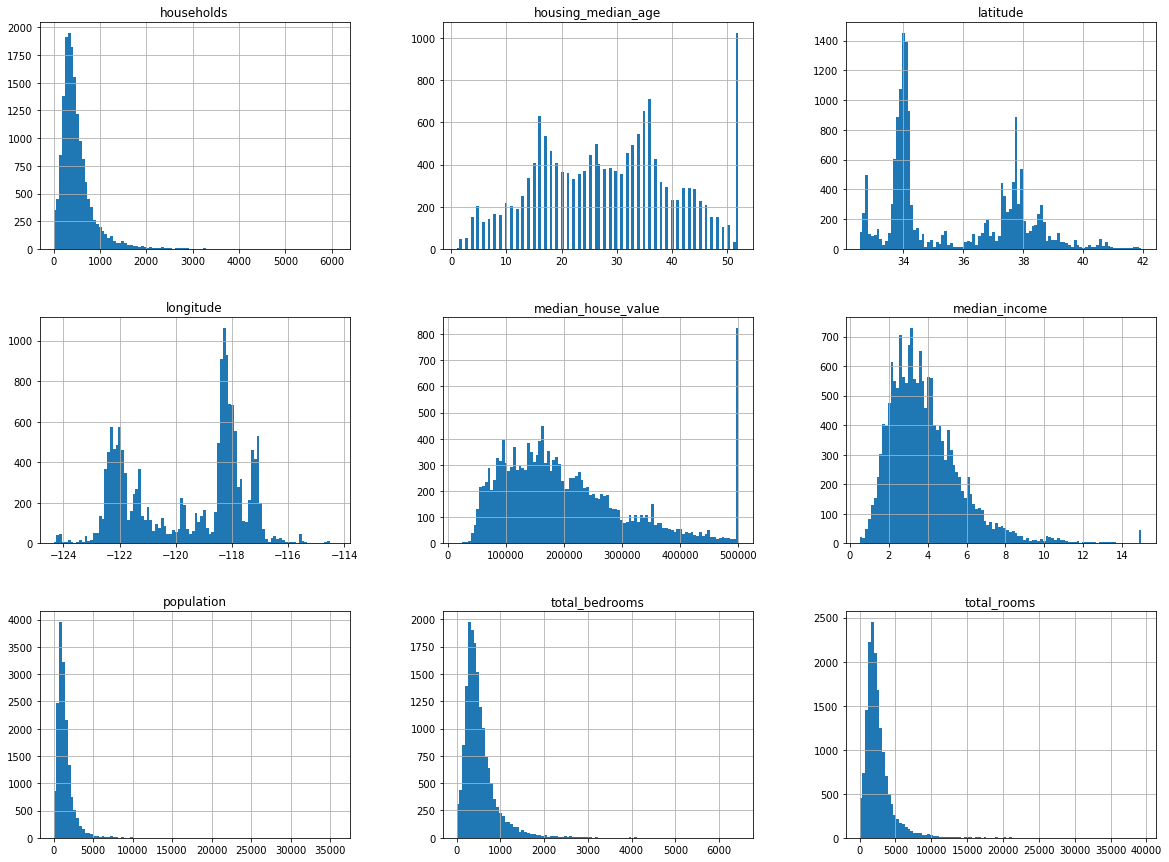

In [1173]:
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

train.hist(bins=100, figsize=(20, 15))
plt.show()

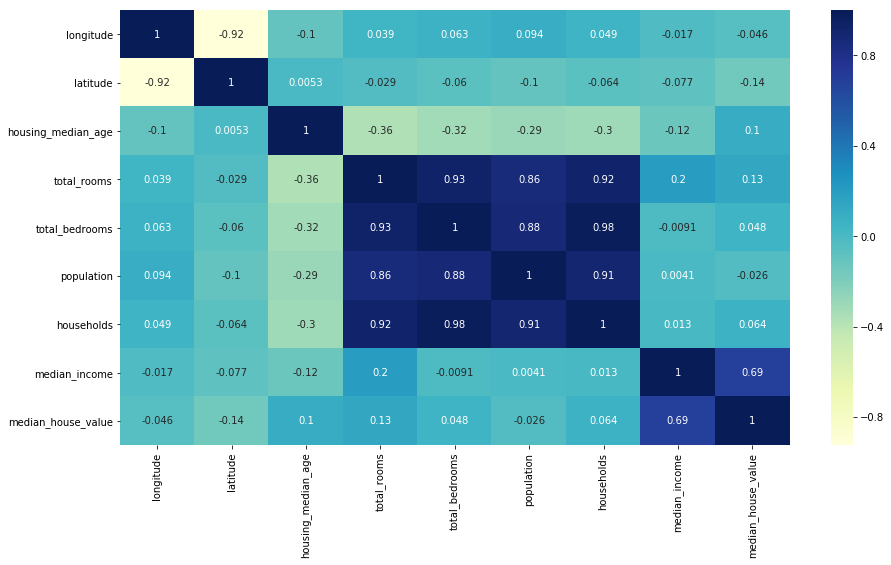

In [1174]:
import seaborn as sns

plt.figure(figsize=(15,8))
corrs = train.corr()
sns.heatmap(corrs, annot=True, cmap="YlGnBu")
plt.show()

In [1175]:
# 3. Data Preprocessing

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce

# 3.1 defining pipelines

# 3.1.1 create base pipeline

class BasePipe(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    
    def fit(self, X):
        return self

# 3.1.2 detecting missing values based on type

class DetectMissingValuesBasedOnType(BasePipe):
    def __init__(self, attr_names, attr_types):
        self.attr_names = attr_names
        self.attr_types = attr_types
        
    def transform(self, X):
        length = len(self.attr_names)
        for i in range(length):
            attr_name = self.attr_names[i]
            attr_type = self.attr_types[i]
            col = X[attr_name]
            if col.dtype == 'O':
                for index, value in col.items():
                    if type(value) != attr_type:
                        col.at[index] = np.nan
        return X
    
# 3.1.3 seperate text and num attrs

class AttributeSelector(BasePipe):
    def __init__(self, attr_names):
        self.attr_names = attr_names
    
    def transform(self, X):
        return X[self.attr_names]
    
# 3.1.4 add attributes

class AddAttributes(BasePipe):
    
    def transform(self, X):
        X_new = X.assign(rooms_per_household=X['total_rooms'] / X['households'],
                population_per_household=X['population'] / X['households'],
                bedrooms_per_room=X['total_bedrooms']/X['total_rooms'])
        return X_new
    
# 3.1.5 transform return as DataFrame

class DataFrameMixin:
    def transform(self, X):
        data = super().transform(X)
        X_new = pd.DataFrame(data=data, index=X.index, columns=X.columns)
        return X_new
    
class SimpleImputerDF(DataFrameMixin, SimpleImputer):
    pass

class StandardScalerDF(DataFrameMixin, StandardScaler):
    pass

In [1176]:
# 3.2 apply pipelines
# 3.2.1 text attributes pipeline


text_pipeline = Pipeline([
    ('selector', AttributeSelector(text_attr_names)),
    ('det_missing', DetectMissingValuesBasedOnType(['ocean_proximity'], [str])),
    ('imp_fre', SimpleImputerDF(strategy="most_frequent")),
    ('encoder', ce.OneHotEncoder(use_cat_names=True)),
])

# 3.2.2 numberical attributes pipeline

num_pipeline = Pipeline([
    ('selector', AttributeSelector(num_attr_names)),
    ('imp_mean', SimpleImputerDF(strategy='mean')),
    ('add_attrs', AddAttributes()),
    ('std_scale', StandardScalerDF()),
])

# 3.2.3 combine text and numberical pipelines

def pipe_X(X):
    num_X = num_pipeline.fit_transform(X)
    text_X = text_pipeline.fit_transform(X)
    piped_X = num_X.join(text_X)
    return piped_X

In [1177]:
# 3.3 feature selection
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

def select_X(X, y, estimator):
    selector = RFECV(estimator, cv=5)
    selector = selector.fit(X, y)
    return selector.support_



# 3.4 full preprocessing

def split_X_y(data):
    data_copy = data.copy(deep=True)
    y = data['median_house_value']
    X = data.drop(columns=['median_house_value'])
    return X, y


def full_preprocessing(data, support=None):
    X_raw, y = split_X_y(data)
    X_piped = pipe_X(X_raw)
    if support is None:
        estimator = LinearRegression()
        support = select_X(X_piped, y, estimator)
        
    X = X_piped.iloc[:, support]
    return X, y, support
        

X, y, support_ = full_preprocessing(train, None)
X_test, y_test, _ = full_preprocessing(test, support_)

In [1178]:
X.shape, y.shape, X_test.shape, y_test.shape

((16512, 15), (16512,), (4128, 15), (4128,))

In [1179]:
# 4. Try Models
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [1185]:
# 4.1 common regressions

## Result-4-1: pick RandomForestRegressor with 0.8143285650298291 cross-validation r2_score

# 4.1.1 cal r2_score for regressions

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

linear_reg = LinearRegression()
ridge_reg = Ridge(alpha=1.0)
tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor(n_estimators=100)
svr_reg = SVR(kernel='linear')


regs = [linear_reg, ridge_reg, tree_reg, forest_reg, svr_reg]
reg_names = ['Linear_reg', 'Ridge_reg', 'Tree_reg', 'Forest_reg', 'SVR_reg']
reg_zip = zip(reg_names, regs)

def print_scores(zip_reg, X, y):
    for reg_name, reg in zip_reg:
        reg.fit(X, y)
        y_pred = reg.predict(X)
        score = r2_score(y, y_pred)
        print(reg_name, ' r2 score is ', score)
        
print_scores(reg_zip, X, y)

Linear_reg  r2 score is  0.6581805562795926
Ridge_reg  r2 score is  0.6581706158320606
Tree_reg  r2 score is  1.0
Forest_reg  r2 score is  0.9749605948214378
SVR_reg  r2 score is  0.08181328647295016


[0.6581805562795926,
 0.6581706158320606,
 1.0,
 0.9749605948214378,
 0.08181328647295016]

In [1184]:
# 4.1.2 cal cross_validation r2_score for regressions


def print_cv_r2_scores(reg_zip, X, y):
    for reg_name, reg in reg_zip:
        scores = cross_val_score(reg, X, y, cv=5, scoring='r2')
        print(reg_name, 'cross-validation r2_score mean is ', scores.mean(), 'with std is ', scores.std())

print_cv_r2_scores(reg_zip, X, y)

Linear_reg cross-validation r2_score mean is  0.6559025764108322 with std is  0.012503199269742096
Ridge_reg cross-validation r2_score mean is  0.655914160684965 with std is  0.012487247786511052
Tree_reg cross-validation r2_score mean is  0.6259640164619957 with std is  0.014760571623806167
Forest_reg cross-validation r2_score mean is  0.8135214592891208 with std is  0.0034094050964791223
SVR_reg cross-validation r2_score mean is  0.057376077958793806 with std is  0.007365527607990933


In [1044]:
# 4.2 votingRegressor

## Result-4-2: Hard VotingRegressor cross-validation r2_score is 0.7262800902364385

# from sklearn.ensemble import VotingRegressor
# update to version >= 0.21

# 4.2.1 cal VotingRegressor r2_score

class CustomVotingRegressor():
    def __init__(self, estimators):
        self.estimators = estimators
        self.estimators_ = []
        self.predicts_ = []
        
    def fit(self, X, y):
        if self.estimators_ == []:
            for estimator in self.estimators:
                estimator_ = estimator.fit(X, y)
                self.estimators_.append(estimator_)
            
    def _predict(self, X, y):
        if self.estimators_ == []:
            raise Exception('fit first')
        for estimator_ in self.estimators_:
            y_pred = estimator_.predict(X)
            self.predicts_.append(y_pred)
        
    def predict(self, X, y):
        self._predict(X, y)
        return np.array(self.predicts_).mean(0)
    
    def cal_voting_r2_score(self, X, y):
        y_preds = self.predict(X, y)
        return r2_score(y, y_preds)
    
linear_reg = LinearRegression()
ridge_reg = Ridge(alpha=1.0)
svr_reg = SVR(kernel='linear')
tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor(n_estimators=100)

estimators = [linear_reg, ridge_reg, svr_reg, tree_reg, forest_reg]

cus_voting_reg = CustomVotingRegressor(estimators)
cus_voting_reg.fit(X, y)

voting_r2_score = cus_voting_reg.cal_voting_r2_score(X, y)

print('Hard Voting r2_score is ', voting_r2_score)

Hard Voting r2_score is  0.8367351920459836


In [1054]:
# 4.2.2 cal VotingRegressor cross-validation r2_score

def cal_votingRegressos_cv_r2_score(X, y, n_splits):
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=False)
    cv_r2_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        cus_voting_reg = CustomVotingRegressor(estimators)
        cus_voting_reg.fit(X_train, y_train)
        cus_voting_r2_score = cus_voting_reg.cal_voting_r2_score(X_val, y_val)
        cv_r2_scores.append(cus_voting_r2_score)
    
    cv_r2_scores_array = np.array(cv_r2_scores)
    mean = cv_r2_scores_array.mean()
    std = cv_r2_scores_array.std()
    
    print('VotingRegressor cross-validation r2_score is ', mean, 'with std is ', std)
        
    return mean, std

cal_votingRegressos_cv_r2_score(X, y, 5)

VotingRegressor cross-validation r2_score is  0.7262800902364385 with std is  0.004375350108506621


(0.7262800902364385, 0.004375350108506621)

In [870]:
# 4.3 baggingRegressor with DecisionTreeRegressor

## Result-4-3: BaggingRegressor oob_score(r2_score) is 0.7413669368115992

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

base_estimator = DecisionTreeRegressor()
bagging = BaggingRegressor(base_estimator=base_estimator, bootstrap=True, oob_score=True)

bagging.fit(X, y)
print(bagging.oob_score_)

0.7413669368115992


/Users/ainesmile/programmer/machine-learning/venv/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:1007: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  predictions[mask] += estimator.predict((X[mask, :])[:, features])


In [1055]:
# 4.4 AdaBoostRegressor

## Result-4-4: Bad Performance

# 4.4.1 base estimator is DecisionTreeRegressor

from sklearn.ensemble import AdaBoostRegressor

adaBoost = AdaBoostRegressor()
cv_adaBoost_scores = cross_val_score(adaBoost, X, y, cv=5, scoring='r2')
cv_adaBoost_score_mean = cv_adaBoost_scores.mean()
cv_adaBoost_score_std = cv_adaBoost_scores.std()

print('AdaBoost(DecisionTree) cross-validation r2_score is ',
      cv_adaBoost_score_mean, ' with std is ', cv_adaBoost_score_std)

AdaBoost(DecisionTree) cross-validation r2_score is  0.39058182957863474  with std is  0.028491732936632017


In [1056]:
# 4.4.2 base estimator is linearRegression

base_estimator = LinearRegression()
adaBoost_linear = AdaBoostRegressor(base_estimator)
cv_adaBoost_linear_scores = cross_val_score(adaBoost_linear, X, y, cv=5, scoring='r2')
cv_adaBoost_linear_mean = cv_adaBoost_linear_scores.mean()
cv_adaBoost_linear_std = cv_adaBoost_linear_scores.std()

print('AdaBoost(LinearRegressor) cross-validation r2_score is ',
      cv_adaBoost_linear_mean, ' with std is ', cv_adaBoost_linear_std)

AdaBoost(LinearRegressor) cross-validation r2_score is  0.643445945072815  with std is  0.010326237935646092


In [1058]:
# 4.5 GradientBoostingRegressor

## Result-4-5: GradientBoostingRegressor cross-validation r2_score is 0.7712162205829346

from sklearn.ensemble import GradientBoostingRegressor

gradientBoost = GradientBoostingRegressor()
cv_gradientBoost_scores = cross_val_score(gradientBoost, X, y, cv=5, scoring='r2')
cv_gradientBoost_score_mean = cv_gradientBoost_scores.mean()
cv_gradientBoost_score_std = cv_gradientBoost_scores.std()
print('GradientBoostingRegressor cross-validation r2_score is ',
    cv_gradientBoost_score, 'with std is ', cv_gradientBoost_scores)

GradientBoostingRegressor cross-validation r2_score is  0.7712162205829346 with std is  [0.7736143  0.77298257 0.7699637  0.77197563 0.76777423]


In [ ]:
# 4.6 pick models
# 1. RandomForestRegressor cross-validation r2_score is 0.8143285650298291
# 2. GradientBoostingRegressor cross-validation r2_score is 0.7712162205829346
# 3. BaggingRegressor oob_score(r2_score) is 0.7413669368115992
# 4. Hard VotingRegressor cross-validation r2_score is 0.7262800902364385


In [885]:
# 5. Model Selection, Hyperparameters Tuning and erary stopping for overfitting

## Result: GradientBoostingRegressor with learning_rate=0.1, n_estimators=600

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [1059]:
# 5.1 RandomForestRegressor

## Result-5-1: 0.8224219089725752

forest_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 10],
    'min_samples_leaf': [10, 40],
}

forest_reg = RandomForestRegressor()

forset_gridSearch = GridSearchCV(forest_reg, param_grid=forest_param_grid, cv=5, scoring='r2')
forset_gridSearch.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100], 'max_depth': [2, 10], 'min_samples_leaf': [10, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [1060]:
forset_gridSearch.best_params_

{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}

In [1061]:
forest_param_grid = {
    'n_estimators': [500, 1000],
}
forest_reg = RandomForestRegressor(oob_score=True)

forset_gridSearch = GridSearchCV(forest_reg, param_grid=forest_param_grid, cv=5, scoring='r2')
forset_gridSearch.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [500, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='r2', verbose=0)

In [1063]:
forset_gridSearch.best_params_

{'n_estimators': 1000}

In [1070]:
forest_reg = RandomForestRegressor(oob_score=True, n_estimators=1000)
forest_reg.fit(X, y)
print(forest_reg.oob_score_)

0.8224219089725752


In [699]:
# 5.2 GradientBoostingRegressor

## Result-5-2: GradientBoostingRegressor cross-validation r2_score 0.8231279682837622

# 5.2.1 GridSearchCV for best params
## Result-5-2-1: {'n_estimators': 1000, 'learning_rate': 0.1}

gradientBoost = GradientBoostingRegressor()

gradient_param_grid = {'n_estimators': [100, 500], 'learning_rate': [0.1, 0.5, 1]}
gradient_grid = GridSearchCV(gradientBoost, gradient_param_grid, cv=5, scoring='r2')
gradient_grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 500], 'learning_rate': [0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [704]:
gradientBoost = GradientBoostingRegressor()

gradient_param_grid = {'n_estimators': [500, 1000], 'learning_rate': [0.01, 0.05, 0.1]}
gradient_grid = GridSearchCV(gradientBoost, gradient_param_grid, cv=5, scoring='r2')
gradient_grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [500, 1000], 'learning_rate': [0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [705]:
gradient_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [905]:
# 5.2.2 early stopping for overfitting

## Result-5-2-2: {'n_estimators': 600, 'learning_rate': 0.1}

from sklearn.model_selection import KFold

best_params = gradient_grid.best_params_
gbrt = GradientBoostingRegressor(
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
)


def cal_staged_cv_scores(n_splits):
    cv_scores = []

    
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=False)
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        gbrt.fit(X_train, y_train)
        
        staged_scores = []

        for y_pred in gbrt.staged_predict(X_val):
            score = r2_score(y_val, y_pred)
            staged_scores.append(score)

        cv_scores.append(staged_scores)
    return cv_scores

    
staged_cv_scores = cal_staged_cv_scores(5)

(0.75, 0.85)

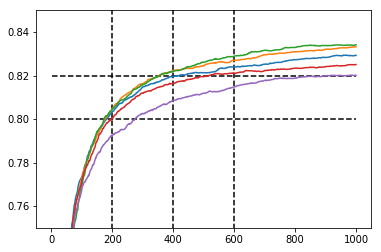

In [1064]:
nums = np.linspace(1, 1000, 1000)
for i in range(5):
    staged_score = staged_cv_scores[i]
    plt.plot(nums, staged_score)

plt.hlines(0.8, 1, 1000, linestyles='dashed')
plt.hlines(0.82, 1, 1000, linestyles='dashed')

plt.vlines(200, 0, 1, linestyles='dashed')
plt.vlines(400, 0, 1, linestyles='dashed')
plt.vlines(600, 0, 1, linestyles='dashed')
plt.ylim(0.75, 0.85)

In [1065]:
# 5.2.3 final result for GradientBoostingRegressor

best_gbrt = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=600,
)

gbrt_r2_score = cross_val_score(best_gbrt, X, y, cv=5, scoring='r2')
print(gbrt_r2_score.mean())

0.8231279682837622


In [916]:
# 5.3 BaggingRegressor

## Result-5-3: 0.8172732100857294

base_estimator = DecisionTreeRegressor()
bagging = BaggingRegressor(
    base_estimator=base_estimator, oob_score=True)

bagging_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.75, 1.0],
    'max_features': [0.8, 1.0],
}

bagging_grid_search = GridSearchCV(bagging, param_grid=bagging_param_grid, scoring='r2', cv=5)
bagging_grid_search.fit(X, y)

/Users/ainesmile/programmer/machine-learning/venv/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:1007: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  predictions[mask] += estimator.predict((X[mask, :])[:, features])
/Users/ainesmile/programmer/machine-learning/venv/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:1007: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  predictions[mask] += estimator.predict((X[mask, :])[:, features])
/Users/ainesmile/programmer/machine-learning/venv/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:1007: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  predictions[mask] += estimator.predict((X[mask, :])[:, features])
/Users/ainesmile/programmer/machine-learning/venv

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
       ...estimators=10, n_jobs=None, oob_score=True,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100], 'max_samples': [0.75, 1.0], 'max_features': [0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [918]:
bagging_grid_search.best_params_, bagging_grid_search.best_estimator_

({'max_features': 0.8, 'max_samples': 1.0, 'n_estimators': 50},
 BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          bootstrap=True, bootstrap_features=False, max_features=0.8,
          max_samples=1.0, n_estimators=50, n_jobs=None, oob_score=True,
          random_state=None, verbose=0, warm_start=False))

In [921]:
bagging = BaggingRegressor(base_estimator=base_estimator, oob_score=True)

bagging_param_grid = {
    'n_estimators': [50, 80],
    'max_features': [0.6, 0.8],
}

bagging_grid_search = GridSearchCV(bagging, param_grid=bagging_param_grid, scoring='r2', cv=5)
bagging_grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
       ...estimators=10, n_jobs=None, oob_score=True,
         random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 80], 'max_features': [0.6, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [923]:
bagging_grid_search.best_params_, bagging_grid_search.best_estimator_

({'max_features': 0.8, 'n_estimators': 50},
 BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          bootstrap=True, bootstrap_features=False, max_features=0.8,
          max_samples=1.0, n_estimators=50, n_jobs=None, oob_score=True,
          random_state=None, verbose=0, warm_start=False))

In [1066]:
best_bagging = bagging_grid_search.best_estimator_
bagging_r2_score = cross_val_score(best_bagging, X, y, cv=5, scoring='r2',)
print(bagging_r2_score.mean())

0.8188609445093226


In [1114]:
# 6. Final Model 

gradient_Boosting = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=600,
)
gradient_Boosting.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=600, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [1120]:
# 6.1 Final Performance

## Result-6-1: Model Performance r2_score, 0.6255364342923583
y_test_preds = gradient_Boosting.predict(X_test)
final_r2_score = r2_score(y_test, y_test_preds)
print(final_r2_score)

0.6255364342923583


In [1145]:
# 6.2 Feature importances

## Result-6-2: median_income, ocean_proximity_<1H OCEAN, longitude, latitude

def show_feature_importances(feature_names, feature_importances):
    importances = zip(feature_names, feature_importances)
    return sorted(importances, key=lambda importance: -importance[1])
feature_names = X.columns.values
feature_importances = show_feature_importances(feature_names, gradient_Boosting.feature_importances_)

[('median_income', 0.5366692147872585), ('ocean_proximity_<1H OCEAN', 0.15339092475359176), ('longitude', 0.09674495223414975), ('latitude', 0.06741472811086358), ('housing_median_age', 0.042600053696617936), ('population', 0.0308868088117944), ('bedrooms_per_room', 0.014519966632448434), ('total_bedrooms', 0.014516784277145587), ('households', 0.011918588609136407), ('rooms_per_household', 0.01040381663353963), ('ocean_proximity_NEAR BAY', 0.008171021603875938), ('total_rooms', 0.0073250156263484556), ('ocean_proximity_NEAR OCEAN', 0.0038242416502526576), ('ocean_proximity_INLAND', 0.0015623674949638694), ('ocean_proximity_ISLAND', 5.1515078013153145e-05)]


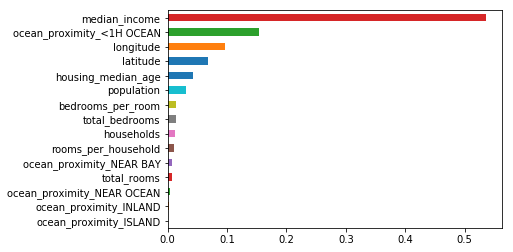

In [1163]:
feat_importances = pd.Series(gradient_Boosting.feature_importances_, index=X.columns)
feat_importances.nsmallest(15).plot(kind='barh')

In [1165]:
# 6.3 Final Model
X_all, y_all, _ = full_preprocessing(data, support_)
final_gradient_boosting = gradient_Boosting.fit(X_all, y_all)